### **Aluna**: Lais de Souza Ziegler
# 🛳️ Predição de sobrevivência em Naufrágio
Dataset: treino.csv

O projeto de predição de sobrevivência em naufrágios utiliza um conjunto de dados inspirado em um incidente recente no Mediterrâneo, contendo informações sobre 7.124 passageiros a bordo de um navio. As variáveis incluem identificação única do passageiro, nome, informações da cabine (deck, número e posição), procedência, destino, idade, status de VIP, modalidade de hospedagem e gastos com serviços a bordo. O objetivo é prever a probabilidade de um passageiro sobreviver ao naufrágio com base em suas características.

### 1️⃣ Leitura e exploração dos dados
---
#### Importando as bibliotecas necessárias para a análise de dados

In [445]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import chebyshev

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, RocCurveDisplay

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder

#### Carregando o conjunto de dados a partir de um arquivo CSV 
- Em seguida, imprimindo os tipos de dados de cada coluna para entender a estrutura do DataFrame
- Exibindo as primeiras cinco linhas do conjunto de dados para uma visão geral dos dados

In [446]:
df = pd.read_csv("treino.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IDpassageiro   1000 non-null   object
 1   Nome           1000 non-null   object
 2   Deck           1000 non-null   object
 3   NumeroCabine   1000 non-null   int64 
 4   PosicaoCabine  1000 non-null   object
 5   Procedencia    1000 non-null   object
 6   Destino        1000 non-null   object
 7   Idade          1000 non-null   int64 
 8   VIP            1000 non-null   bool  
 9   AllInclusive   1000 non-null   bool  
 10  ServicoCabine  1000 non-null   int64 
 11  Restaurante    1000 non-null   int64 
 12  Shopping       1000 non-null   int64 
 13  SPA            1000 non-null   int64 
 14  ParquedeAguas  1000 non-null   int64 
 15  Sobrevivente   1000 non-null   bool  
dtypes: bool(3), int64(7), object(6)
memory usage: 104.6+ KB


,IDpassageiro,Nome,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente
0,5647_02,Chabih Matoltuble,D,193,P,Finland,Peru,61,False,True,239,1288,3380,1158,587,True
1,0107_01,Coobix Hart,A,1202,S,Argentina,Argentina,31,True,False,466,6,11299,1598,506,True
2,4158_01,Doryn Noeley,G,107,P,Peru,China,49,True,True,1240,674,10989,806,463,True
3,1316_01,Sadrus Quelfly,G,545,S,Indonesia,Greenland,32,False,True,176,1186,8750,1438,379,True
4,9069_05,Mirfark Taketiatim,D,392,P,Indonesia,Brazil,5,False,False,90,1318,161,2853,203,True


#### Exibindo a forma do DataFrame, que retorna o número de linhas e colunas, 

In [447]:
print(df.shape)

(1000, 16)


#### Exibindo um resumo estatístico das colunas numéricas do DataFrame

In [448]:
df.describe()

,NumeroCabine,Idade,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,688.466000,39.816000,883.92700,690.624000,7410.141000,1518.977000,356.879000
std,404.869011,23.346203,498.44474,419.069741,4413.046425,861.974722,202.812532
min,1.000000,0.000000,4.00000,3.000000,2.000000,0.000000,0.000000
25%,332.750000,19.000000,473.50000,312.750000,3666.750000,797.750000,184.000000
50%,675.000000,40.000000,878.00000,680.000000,7309.000000,1472.500000,365.500000
75%,1049.500000,61.000000,1297.50000,1045.500000,11279.750000,2297.500000,532.000000
max,1365.000000,79.000000,1741.00000,1425.000000,15234.000000,2955.000000,705.000000


### Verificando se há valores ausentes

In [449]:
df.isnull().sum()

IDpassageiro     0
Nome             0
Deck             0
NumeroCabine     0
PosicaoCabine    0
Procedencia      0
Destino          0
Idade            0
VIP              0
AllInclusive     0
ServicoCabine    0
Restaurante      0
Shopping         0
SPA              0
ParquedeAguas    0
Sobrevivente     0
dtype: int64

## Análise de Passageiros em Família e Solo
Identificar se os passageiros se estão viajando sozinhos ou em grupo (família) com base em um identificador fornecido.

- Separar o ID de Grupo e o Número do Integrante
    - Dividimos o identificador único de cada passageiro (`IDpassageiro`) em duas partes: o grupo ao qual o passageiro pertence e o número de cada integrante dentro desse grupo. Isso nos permite rastrear quantos passageiros fazem parte de cada grupo.

- Identificar se o Passageiro está em Família
    - Com a contagem de passageiros por grupo, marcamos os passageiros que pertencem a grupos com mais de um integrante como "Em Grupo", e os demais como "Solo".


In [450]:
df[['Grupo', 'Integrante']] = df['IDpassageiro'].str.split('_', expand=True)

group_counts = df['Grupo'].value_counts()

df['EmGrupo'] = df['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

print(df.EmGrupo.value_counts())

EmGrupo
0    895
1    105
Name: count, dtype: int64


### Visualizar a Distribuição de Passageiros em Família e Solo
Gráfico de barras para mostrar visualmente a quantidade de passageiros que viajam sozinhos em comparação aos que viajam em grupo, facilitando a análise da distribuição entre esses dois tipos de passageiros.

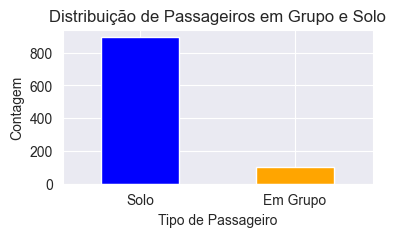

In [451]:
plt.figure(figsize=(4, 2))
df['EmGrupo'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Solo', 'Em Grupo'], rotation=0)
plt.title('Distribuição de Passageiros em Grupo e Solo')
plt.xlabel('Tipo de Passageiro')
plt.ylabel('Contagem')
plt.show()

### Visualizar a Distribuição de Passageiros por Deck
Mostrando visualmente a quantidade de passageiros em cada Deck do navio.

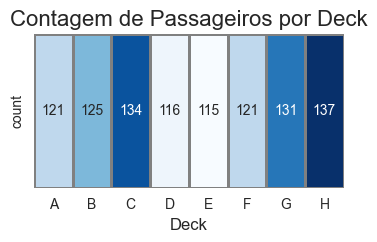

In [452]:
deck_counts = df['Deck'].value_counts().reset_index()
deck_counts_sorted = deck_counts.sort_values(by='Deck', ascending=True)
deck_counts.columns = ['Deck', 'Contagem']

plt.figure(figsize=(4, 2))
sns.heatmap(deck_counts_sorted.set_index('Deck').T, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='gray')

plt.title('Contagem de Passageiros por Deck', fontsize=16)
plt.xlabel('Deck', fontsize=12)
plt.show()

### Visualizar a Distribuição de Passageiros e a Posição da Cabine
Mostrando visualmente a quantidade de passageiros em cada Deck do navio.

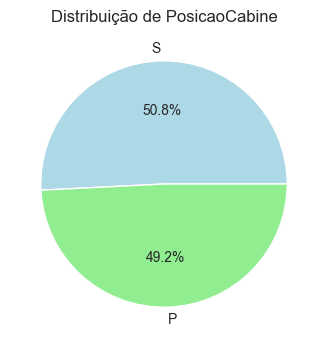

In [453]:
plt.figure(figsize=(6, 4))
df['PosicaoCabine'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Distribuição de PosicaoCabine')
plt.ylabel('') 
plt.show()

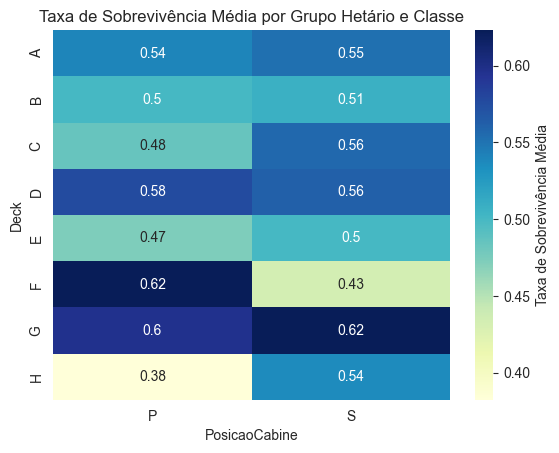

In [454]:
pivot_table = df.pivot_table(values="Sobrevivente", index="Deck", columns="PosicaoCabine", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

## Preparação de Dados

- **Codificação de variáveis**
   - `Deck` foi transformado em códigos numéricos.
   - `PosicaoCabine` foi mapeada para 1 (P) e 0 (S).
   - Colunas booleanas (`VIP`, `AllInclusive`, `Sobrevivente`) foram convertidas para 0 e 1.

- **Criação de novas colunas**
   - `TotalGasto` foi calculado somando os gastos em diferentes categorias.
   - `GrupoHetario` e `RangeGasto` foram criados para agrupar idade e gastos em faixas.

- **Conversão para códigos numéricos**: 
   - `GrupoHetario` e `RangeGasto` foram convertidos para valores numéricos.

- **Origem e destino**:
   - `MesmaOrigemDestino` foi criada para indicar se a procedência e destino são iguais.

- **Remoção de colunas**: 
   - Colunas de gastos individuais foram removidas.
   - Colunas desnecessárias e dados redundantes


In [455]:
# df['Deck'] = df['Deck'].astype('category').cat.codes
# df['PosicaoCabine'] = df['PosicaoCabine'].map({'P': 1, 'S': 0})
df = pd.get_dummies(df, columns=['Deck', 'PosicaoCabine'], drop_first=True)


df['VIP'] = df['VIP'].astype(int)
df['AllInclusive'] = df['AllInclusive'].astype(int)
df['Sobrevivente'] = df['Sobrevivente'].astype(int)

df['TotalGasto'] = df[['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas']].sum(axis=1)

df['GrupoHetario'] = pd.cut(df['Idade'], bins=[-1, 18, 30, 50, 100], labels=["0-18", "19-30", "31-50", "51+"])
df['RangeGasto'] = pd.cut(df['TotalGasto'], bins=[-1, 500, 1000, 2000, 5000, 10000, 30000], labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5001-10000', '10000+'], right=False)

df['GrupoHetarioCode'] = df['GrupoHetario'].cat.codes
df['RangeGastoCode'] = df['RangeGasto'].cat.codes

df['MesmaOrigemDestino'] = (df['Procedencia'] == df['Destino']).astype(int)

In [456]:
df[['Idade', 'TotalGasto']].describe()


,Idade,TotalGasto
count,1000.000000,1000.000000
mean,39.816000,10860.548000
std,23.346203,4502.086445
min,0.000000,1637.000000
25%,19.000000,6891.000000
50%,40.000000,10831.000000
75%,61.000000,14615.250000
max,79.000000,20416.000000


In [457]:
# correlation = df.corr()
# print(correlation['Sobrevivente'].sort_values(ascending=False))


C:\Users\Lais_Ziegler\AppData\Local\Temp\ipykernel_58304\3535139201.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="AllInclusive", aggfunc="mean")


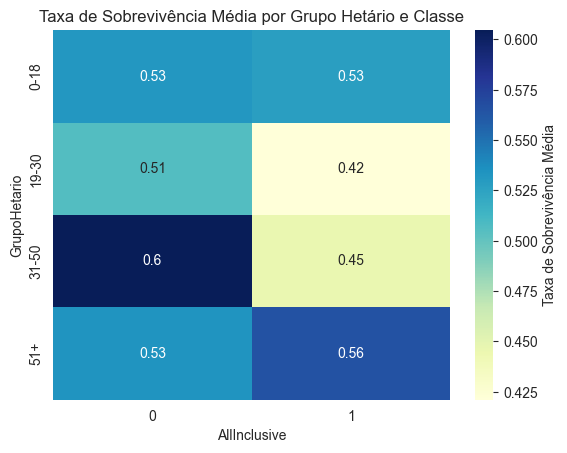

C:\Users\Lais_Ziegler\AppData\Local\Temp\ipykernel_58304\3535139201.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="AllInclusive", aggfunc="mean")


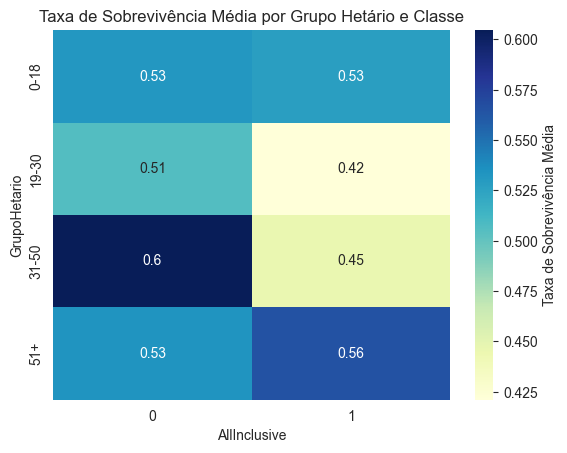

In [458]:
pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="AllInclusive", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="AllInclusive", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

In [459]:
df.drop(['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas', 'IDpassageiro', 'Nome', 'Procedencia', 'Destino', 'NumeroCabine', 'GrupoHetario', 'RangeGasto', 'TotalGasto', 'Integrante', 'Grupo'], axis=1, inplace=True)

#### Separando os atributos do conjunto de dados em variáveis independentes (X) e a variável dependente (y).
- As variáveis independentes são todas as colunas do DataFrame, exceto 'Sobrevivente', que é removida. 
- A variável dependente 'Sobrevivente' é isolada em y.

#### Dividir os dados em conjuntos de treinamento e teste

In [460]:
X = df.drop(["Sobrevivente"], axis=1)
y = df["Sobrevivente"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelo 1: Regressão Logística
### Análise e ajuste dos hiper-parâmetros da Regressão Logística
- Escalonando os dados (normalizando para ter média 0 e desvio padrão 1)

In [461]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {grid_search.best_score_}")

Melhores parâmetros: {'C': 0.1, 'max_iter': 100, 'solver': 'saga'}
Acurácia: 0.5237499999999999


- Definição de parâmetros
- Treinando o modelo
- Fazendo as previsões
- Calculando acurácia no conjunto de treino
- Exibindo a acurácia

In [462]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.1)
logreg.fit(X_train_scaled, y_train)
Y_pred = logreg.predict(X_test_scaled)
acc_log = round(logreg.score(X_train_scaled, y_train) * 100, 2)
print(f'Acurácia no conjunto de treino: {acc_log}%')

Acurácia no conjunto de treino: 55.38%


In [463]:
from sklearn.metrics import precision_score

# Calculando as métricas
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred)
conf_matrix = confusion_matrix(y_test, Y_pred)

# Imprimindo os resultados
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

Acurácia: 0.49
Precisão: 0.51
Revocação: 0.68
F1-score: 0.58

Matriz de Confusão:
[[28 68]
 [33 71]]


In [464]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.46      0.29      0.36        96
           1       0.51      0.68      0.58       104

    accuracy                           0.49       200
   macro avg       0.48      0.49      0.47       200
weighted avg       0.49      0.49      0.48       200



C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


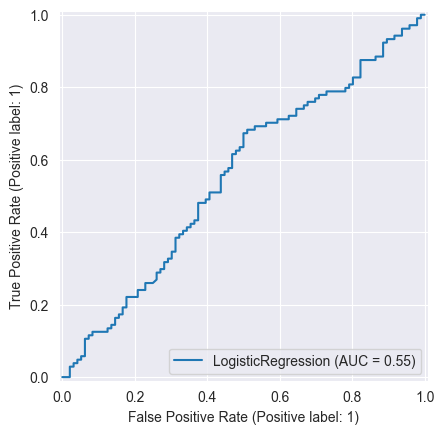

In [465]:
#Curva ROC
RocCurveDisplay.from_estimator(logreg, X_test, y_test)

### Modelo 2: Árvores de Decisão
### Análise e ajuste dos hiper-parâmetros de Árvores de Decisão
- Escalonando os dados

In [466]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)

Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}


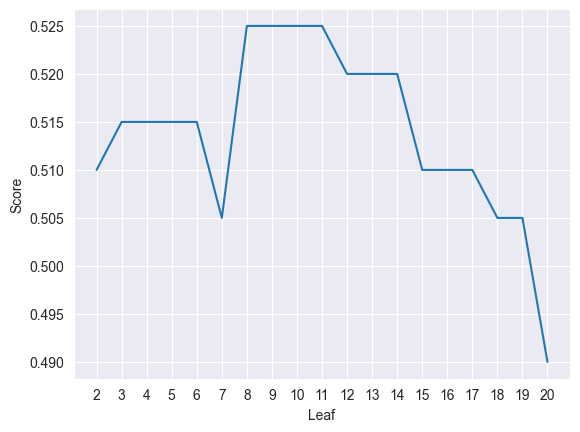

Acurácia do algoritmo de Árvore de Decisão: 52.50%


In [467]:
scoreListDT = []
for i in range(2,21):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i, max_depth=15, min_samples_split=5, min_samples_leaf=1)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))

plt.plot(range(2,21), scoreListDT)
plt.xticks(np.arange(2,21,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAcc = max(scoreListDT)
print("Acurácia do algoritmo de Árvore de Decisão: {:.2f}%".format(DTAcc*100))

In [468]:
from sklearn.tree import export_text

# apresentações do modelo
modelo_txt = export_text(DTclassifier, feature_names=list(X.columns))
print(modelo_txt)

|--- Deck_H <= 0.50
|   |--- MesmaOrigemDestino <= 0.50
|   |   |--- Deck_G <= 0.50
|   |   |   |--- Idade <= 76.50
|   |   |   |   |--- Idade <= 46.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Idade >  46.50
|   |   |   |   |   |--- Idade <= 51.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Idade >  51.50
|   |   |   |   |   |   |--- Deck_B <= 0.50
|   |   |   |   |   |   |   |--- Idade <= 69.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Idade >  69.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Deck_B >  0.50
|   |   |   |   |   |   |   |--- Idade <= 70.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Idade >  70.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- Idade >  76.50
|   |   |   |   |--- VIP <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- VIP >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- Deck_G >  0.50
| 

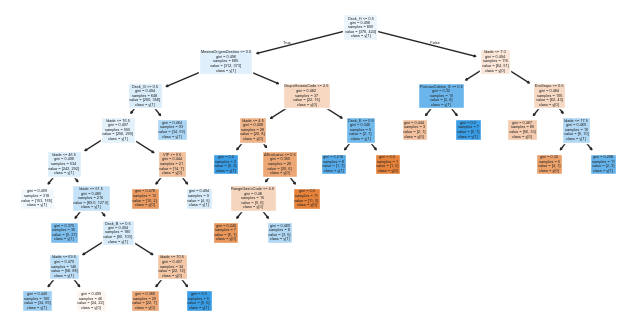

In [469]:
from sklearn.tree import plot_tree

plt.figure(figsize=(8, 4))  # Tamanho da figura
plot_tree(DTclassifier, feature_names=X.columns, class_names=True, filled=True)
plt.show()

In [470]:
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
acc_decision_tree_train = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de treino: {acc_decision_tree_train}%")
print(f"Acurácia no conjunto de teste: {acc_decision_tree_test}%")
# Previsões no conjunto de teste
y_pred = decision_tree.predict(X_test)

Acurácia no conjunto de treino: 71.25%
Acurácia no conjunto de teste: 46.0%


In [471]:
# Calculando as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimindo os resultados
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

Acurácia: 0.46
Precisão: 0.48
Revocação: 0.49
F1-score: 0.49

Matriz de Confusão:
[[41 55]
 [53 51]]


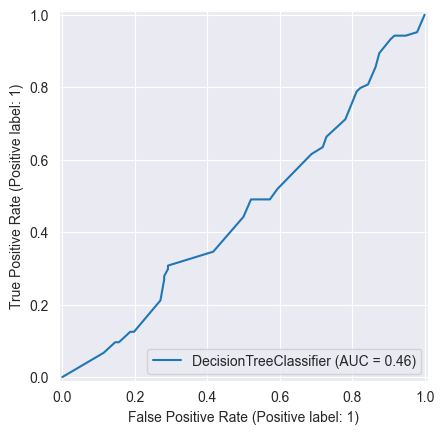

In [472]:
#Curva ROC
RocCurveDisplay.from_estimator(decision_tree, X_test, y_test)


In [473]:
scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5, scoring='accuracy')
print("Acurácia média:", scores.mean())

Acurácia média: 0.525


In [474]:
# from xgboost import XGBClassifier
#
# # Definindo o modelo
# xgboost_model = XGBClassifier(random_state=42)
#
# # Definindo os hiperparâmetros que queremos otimizar
# param_grid = {
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.5],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [0, 0.1, 1]
# }
#
# # GridSearchCV para buscar os melhores parâmetros
# grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
#                            scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
#
# # Treinando o modelo com GridSearchCV
# grid_search.fit(X_train, y_train)
#
# # Melhor conjunto de parâmetros
# print("Melhores parâmetros encontrados:")
# print(grid_search.best_params_)
#
# # Melhor resultado de acurácia
# print("Melhor acurácia:", grid_search.best_score_)
#
# # Melhor modelo
# best_model = grid_search.best_estimator_
#
# # Acurácia no conjunto de teste com o melhor modelo
# acc_test_best_model = best_model.score(X_test, y_test)
# print(f"Acurácia no conjunto de teste com o melhor modelo: {acc_test_best_model * 100:.2f}%")

In [475]:
# from xgboost import XGBClassifier
#
# # Treinando o modelo XGBoost
# xgboost_model = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=50, random_state=42)
# xgboost_model.fit(X_train, y_train)
#
# # Acurácia no conjunto de treino e teste
# acc_xgboost_train = round(xgboost_model.score(X_train, y_train) * 100, 2)
# acc_xgboost_test = round(xgboost_model.score(X_test, y_test) * 100, 2)
#
# # Previsões no conjunto de teste
# y_pred = xgboost_model.predict(X_test)
#
# # Calculando as métricas
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
#
# # Exibindo os resultados
# print(f"Acurácia no conjunto de treino: {acc_xgboost_train}%")
# print(f"Acurácia no conjunto de teste: {acc_xgboost_test}%")
# print(f"Acurácia geral (teste): {accuracy:.2f}")
# print(f"Precisão: {precision:.2f}")
# print(f"Revocação: {recall:.2f}")
# print(f"F1-score: {f1:.2f}")
# print("\nMatriz de Confusão:")
# print(conf_matrix)

### Modelo 3: K-Nearest Neighbors
### Análise e ajuste dos hiper-parâmetros do KNN

In [476]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir o grid de parâmetros
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'cosine']
}

# Criar o modelo KNN
knn = KNeighborsClassifier()

# Fazer o GridSearch
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Melhor combinação de parâmetros
print("Melhor métrica:", grid_search.best_params_['metric'])
print("Melhor número de vizinhos:", grid_search.best_params_['n_neighbors'])
print("Melhor precisão:", grid_search.best_score_)

Melhor métrica: manhattan
Melhor número de vizinhos: 10
Melhor precisão: 0.5462499999999999


In [477]:
knn = KNeighborsClassifier(n_neighbors = 3, metric = 'manhattan')
knn.fit(X_train_scaled, y_train)
Y_pred = knn.predict(X_test_scaled)
acc_knn = round(knn.score(X_train_scaled, y_train) * 100, 2)
acc_knn

75.0

C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


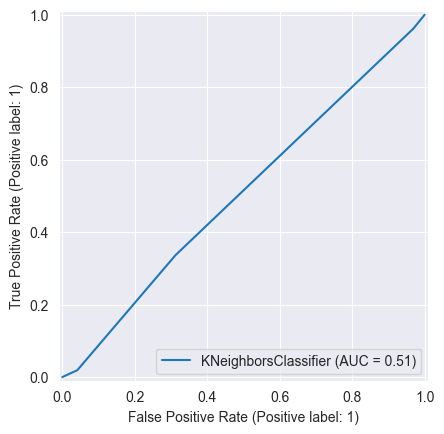

In [478]:
#Curva ROC
RocCurveDisplay.from_estimator(knn, X_test, y_test)

### Modelo 4: Gaussian Naive Bayes
### Análise e ajuste dos hiper-parâmetros da Naive Bayes

In [479]:
NBclassifier1 = GaussianNB()
NBclassifier1.fit(X_train, y_train)

y_pred = NBclassifier1.predict(X_test)

print(classification_report(y_test, y_pred))
print('Matriz de confusão: ')
print(confusion_matrix(y_test, y_pred))
acc_gaussian = round(NBclassifier1.score(X_train, y_train) * 100, 2)
NBAcc1 = accuracy_score(y_pred,y_test)
print('Acurácia do algoritmo de Naive Bayes: {:.2f}%'.format(NBAcc1*100))

              precision    recall  f1-score   support

           0       0.48      0.33      0.39        96
           1       0.52      0.66      0.58       104

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.51      0.49       200

Matriz de confusão: 
[[32 64]
 [35 69]]
Acurácia do algoritmo de Naive Bayes: 50.50%


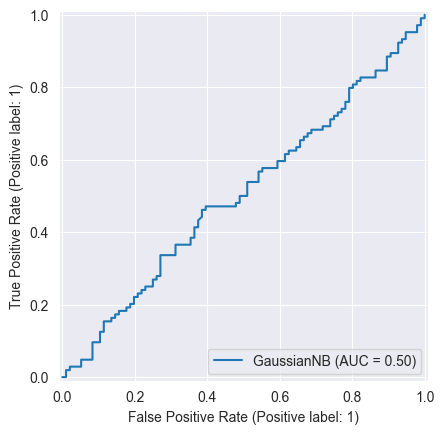

In [480]:
#Curva ROC
RocCurveDisplay.from_estimator(NBclassifier1, X_test, y_test)

### Modelo 5: Random Forest
### Análise e ajuste dos hiper-parâmetros de Random Foest

In [481]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
acc_rf_train = round(rf.score(X_train, y_train) * 100, 2)
# acc_rf_test = round(rf.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de treino (Random Forest): {acc_rf_train}%")
# print(f"Acurácia no conjunto de teste (Random Forest): {acc_rf_test}%")

Acurácia no conjunto de treino (Random Forest): 71.0%


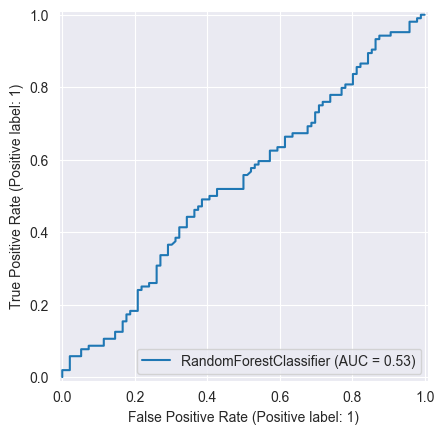

In [482]:
#Curva ROC
RocCurveDisplay.from_estimator(rf, X_test, y_test)

In [483]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Gaussian Naive Bayes',
              'Decision Tree'],
    'Score': [acc_knn, acc_log, 
              acc_rf_train, acc_gaussian,
             acc_decision_tree_train]})
models.sort_values(by='Score', ascending=False)




,Model,Score
0,KNN,75.00
4,Decision Tree,71.25
2,Random Forest,71.00
3,Gaussian Naive Bayes,56.12
1,Logistic Regression,55.38
